# CRAR

In [4]:
import math
import torch
import torch.nn as nn
from torch.optim import Adam
import gym
from utils import ReplayBuffer
import random
import numpy as np

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
device = torch.device(device)

In [7]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## CartPole

In [8]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [9]:
from model import SimpleQNetwork
model = SimpleQNetwork(env.observation_space.shape, env.action_space.n, device).to(device)
optimizer = Adam(model.parameters())
replay_buffer = ReplayBuffer(1000)

In [14]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

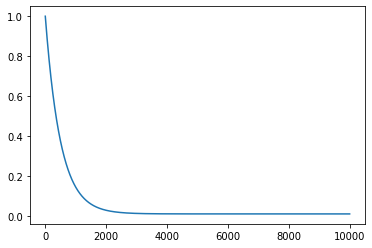

In [15]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [16]:
from loss import q_td_loss_optim
compute_td_loss = q_td_loss_optim

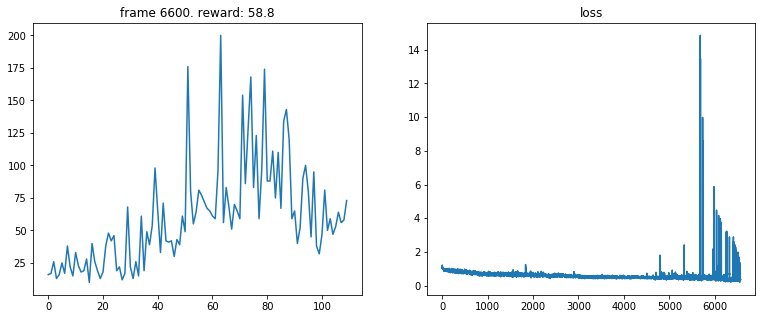

In [17]:
num_frames = 10000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size, gamma, model, optimizer, replay_buffer, device)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        plot(frame_idx, all_rewards, losses)

## Pong

In [4]:
from wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [5]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

In [7]:
from model import QNetwork
model = QNetwork(env.observation_space.shape, env.action_space.n, device).to(device)
optimizer = Adam(model.parameters(), lr=0.00001)
replay_initial = 1000
replay_buffer = ReplayBuffer(100000)

In [8]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 100000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [9]:
from loss import q_td_loss_optim
compute_td_loss = q_td_loss_optim

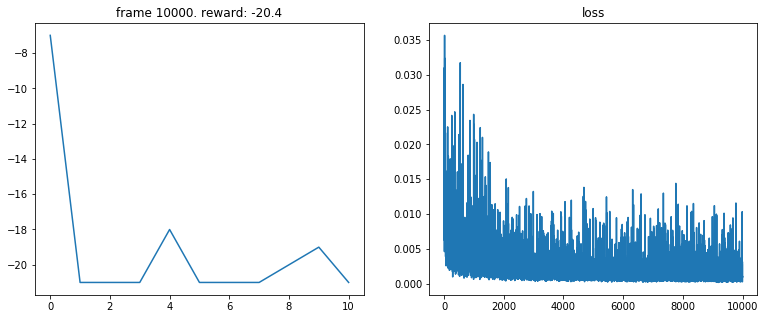

KeyboardInterrupt: 

In [14]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = model.act(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size, gamma, model, optimizer, replay_buffer, device)
        losses.append(loss.data.item())
        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

In [13]:
torch.save(model.state_dict(), 'saved_weights/qnetwork.pt')

In [12]:
model.load_state_dict(torch.load('saved_weights/qnetwork.pt'))

<All keys matched successfully>